In [1]:
# import pykeops
# pykeops.clean_pykeops()          # just in case old build files are still present
# pykeops.test_numpy_bindings()    # perform the compilation

In [1]:
import os
import torch, pyro, numpy as np
torch.set_default_tensor_type(torch.cuda.FloatTensor)
from torch import tensor
import torch.nn as nn
import torchvision.transforms.functional as TF


from clipppy import load_config, Clipppy
from clipppy.patches import torch_numpy
from ruamel.yaml import YAML

import swyft
import pyro.distributions as dist

import matplotlib.pyplot as plt
imkwargs = dict(extent=(-2.5, 2.5, -2.5, 2.5), origin='lower')

import sys
sys.path.append('/home/eliasd/lensing/elias_utils')
from plotting import *

DEVICE = 'cuda'

In [2]:
SYSTEM_NAME = "ngc4414"
NSIM = 10000
NSIM = 100
# SIM_PATH = f'/nfs/scratch/eliasd/store-ring-1x1.zarr' 
# SIM_PATH = f'/nfs/scratch/eliasd/store.zarr' 
SIM_PATH = f'/nfs/scratch/eliasd/store-test.zarr' 

DSLnet = 'DSLnet-test.pt'
UNet =  'UNet-test.pt'

SIGMA = 0.1

### Utilities

In [43]:
def get_config(system_name: str) -> Clipppy:
    """
    Get configuration
    """
    torch.set_default_tensor_type(torch.cuda.FloatTensor)  # HACK

    SOURCE_DIR = '../../mock_data/sources'
        
    source_name = f'{system_name}.npy'
    config = load_config('config-sub.yaml', base_dir=SOURCE_DIR)

    torch.set_default_tensor_type(torch.FloatTensor)  # HACK
    return config


def get_prior(config: Clipppy):
    """
    Set up subhalo parameter priors using a config
    """
    main = config.umodel.alphas["main"]
    prior_p_sub = main.sub.pos_sampler.base_dist
    lows = np.array(
        [
            prior_p_sub.low[0].item(),
            prior_p_sub.low[1].item(),
        ]
    )
    highs = np.array(
        [
            prior_p_sub.high[0].item(),
            prior_p_sub.high[1].item(),
        ]
    )
    uv = lambda u: (highs - lows) * u + lows
    
    print(lows, lows.shape)
    print(highs, highs.shape)
    
    return swyft.Prior(uv, 2), uv

def simul(v, config: Clipppy):
    """
    Fix values for main lens and source parameters from config and put
    in a subhalo with the specified position and mass.

    Arguments
    - v: array containing x_sub, y_sub.

    Returns
    - Numpy array.
    """
    torch.set_default_tensor_type(torch.cuda.FloatTensor)  # HACK
    
    from pyrofit.lensing.utils import get_meshgrid  # import here due to HACKs
    nx = config.kwargs["defs"]["nx"]
    ny = config.kwargs["defs"]["ny"]
    res = config.kwargs["defs"]["res"]
    X, Y = config.umodel.X.clone(), config.umodel.Y.clone()
    # Upsample image
    upsample = 10
    config.umodel.coerce_XY(*get_meshgrid(res / upsample, nx * upsample, ny * upsample))
        
    x_sub, y_sub = np.squeeze(v.T)
    print(x_sub, y_sub)
    print(torch.stack([x_sub, y_sub]).T)
    d_p_sub = dist.Delta(torch.stack([x_sub, y_sub]).T).to_event(1)
    print(d_p_sub)

    
#     print(d_p_sub)

#     d_p_sub = dist.Delta(v).to_event(1)
#     d_p_sub = dist.Delta(v.view(-1, 2)).to_event(1)

#     print(d_p_sub)



    def _guide():
        # Sample subhalo position
        guide_sample = {
            "main/sub/p_sub": pyro.sample("main/sub/p_sub", d_p_sub),
        }

        return guide_sample
    
    result = {
        "image": CONFIG.ppd(guide=_guide)["model_trace"]
        .nodes["mu"]["value"]
        .detach()
        .numpy()
    }
    
    # Restore coarse grid
    config.umodel.coerce_XY(X, Y)
    # Downsample image
    averager = torch.nn.AvgPool2d((upsample, upsample))
    result['image'] = (averager(torch.tensor(result['image']).unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0))

    torch.set_default_tensor_type(torch.FloatTensor)  # HACK
    return result

def noise(obs, _=None, sigma_n=SIGMA):
    image = obs["image"]
    eps = np.random.randn(*image.shape) * sigma_n
    return {"image": image + eps}


def simul(v, config: Clipppy):
    """
    Fix values for main lens and source parameters from config and put
    in a subhalo with the specified position and mass.

    Arguments
    - v: array containing x_sub, y_sub.

    Returns
    - Numpy array.
    """
    torch.set_default_tensor_type(torch.cuda.FloatTensor)  # HACK
    
    from pyrofit.lensing.utils import get_meshgrid  # import here due to HACKs
    nx = config.kwargs["defs"]["nx"]
    ny = config.kwargs["defs"]["ny"]
    res = config.kwargs["defs"]["res"]
    X, Y = config.umodel.X.clone(), config.umodel.Y.clone()
    
    # Upsample image
    upsample = 1
    config.umodel.coerce_XY(*get_meshgrid(res / upsample, nx * upsample, ny * upsample))
        
    x_sub, y_sub = np.squeeze(v.T)
    d_p_sub = dist.Delta(torch.tensor([x_sub, y_sub])).to_event(1)
    
    x0 = np.random.uniform(-0.4, 0.4)
    y0 = np.random.uniform(-0.4, 0.4)
    r = np.random.uniform(0.5, 1.5)
    w = np.random.uniform(0.1, 0.3)
    R = ((X-x0)**2 + (Y-y0)**2)**0.5
    ring = np.exp(-(R-r)**2/w**2/2) 
    
    w_sub = np.random.uniform(0.1, 0.3)
    R_sub = ((X-x_sub)**2 + (Y-y_sub)**2)**0.5
    halo  = np.exp(-(R_sub)**2/w_sub**2/2)
        
    result = {"image": ring + halo}
    
    # Restore coarse grid
#     config.umodel.coerce_XY(X, Y)
    # Downsample image
#     averager = torch.nn.AvgPool2d((upsample, upsample))
#     result['image'] = (averager(torch.tensor(result['image']).unsqueeze(0).unsqueeze(0)).squeeze(0).squeeze(0))

    torch.set_default_tensor_type(torch.FloatTensor)  # HACK
    return result

### Check utilities

In [44]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)  # HACK
CONFIG = get_config(SYSTEM_NAME)
torch.set_default_tensor_type(torch.FloatTensor)

In [45]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)  # HACK
ppd = CONFIG.ppd()['model_trace'].nodes
torch.set_default_tensor_type(torch.FloatTensor)

In [31]:
v = ppd['main/sub/p_sub']['value']
print(v)
sim = simul(v, CONFIG)

tensor([[ 2.0158,  0.8878],
        [ 0.7852,  0.3305],
        [-2.0598, -2.1784],
        [ 0.9808,  2.0543],
        [-2.3090, -0.6179]], device='cuda:0')
tensor([ 2.0158,  0.7852, -2.0598,  0.9808, -2.3090]) tensor([ 0.8878,  0.3305, -2.1784,  2.0543, -0.6179])
tensor([[ 2.0158,  0.8878],
        [ 0.7852,  0.3305],
        [-2.0598, -2.1784],
        [ 0.9808,  2.0543],
        [-2.3090, -0.6179]])
Independent(Delta(v: torch.Size([5, 2]), log_density: torch.Size([5, 2])), 1)


In [28]:
vv = tensor([[-2.2374,  0.6018],
        [ 2.1324, -2.1556],
        [-1.8904,  0.0949],
        [ 0.4877,  2.4880],
        [-1.4744,  1.5439]])

vv[:,0].cpu(),  v[...,0].cpu()

(tensor([-2.2374,  2.1324, -1.8904,  0.4877, -1.4744]),
 tensor([-2.2374,  2.1324, -1.8904,  0.4877, -1.4744]))

In [51]:
v = tensor(np.random.rand(10, 2)).to(DEVICE)
v[..., 0]

tensor([0.8946, 0.0868, 0.0149, 0.3378, 0.4054, 0.8624, 0.6283, 0.4801, 0.3422,
        0.0318], device='cuda:0', dtype=torch.float64)

In [99]:
# # v = ppd['main/sub/p_sub']['value']
# # # v = tensor(uv(np.random.rand(10, 2))).to(DEVICE)

# # sim = simul(v, CONFIG)
# # print(v)

# # plt.imshow(sim['image'].cpu(), **imkwargs)
# # plt.scatter(*v.t(), marker = 'x', c = 'r')

tensor([ 2.0158,  0.7852, -2.0598,  0.9808, -2.3090]) tensor([ 0.8878,  0.3305, -2.1784,  2.0543, -0.6179])
tensor([[ 2.0158,  0.8878],
        [ 0.7852,  0.3305],
        [-2.0598, -2.1784],
        [ 0.9808,  2.0543],
        [-2.3090, -0.6179]])
Independent(Delta(v: torch.Size([5, 2]), log_density: torch.Size([5, 2])), 1)


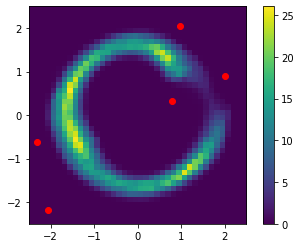

In [32]:
# v = tensor(((0.3, 0.1), (0.2, 0.4)), (0.)).to(DEVICE)
v = ppd['main/sub/p_sub']['value']
# sim = simul(v, CONFIG)
plt.scatter(*v.t(), c="r")
plt.imshow(simul(v, CONFIG)['image'], **imkwargs)
plt.colorbar()
plt.show()

Independent(Delta(v: torch.Size([10, 2]), log_density: torch.Size([10, 2])), 1)


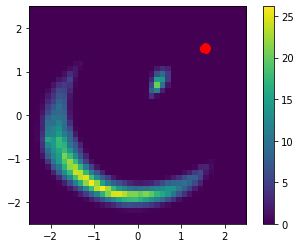

In [52]:
nnsub = 10
v = tensor(np.random.uniform(1.5, 1.6, (2*nnsub,))).to(DEVICE)
plt.scatter(*v.view(-1,2).t(), c="r")
plt.imshow(simul(v, CONFIG)['image'], **imkwargs)
plt.colorbar()
plt.show()

Independent(Delta(v: torch.Size([10, 2]), log_density: torch.Size([10, 2])), 1)
Independent(Delta(v: torch.Size([10, 2]), log_density: torch.Size([10, 2])), 1)


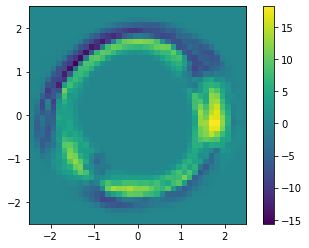

In [62]:
v_1 = tensor(np.random.uniform(-2.5, 2.5, (20,))).to(DEVICE)
v_2 = tensor(np.random.uniform(-2.5, 2.5, (20,))).to(DEVICE)
# print(v_1)
# plt.scatter(*v_1, marker = 'x')
# plt.scatter(*v_2,  marker = 'x')
plt.imshow(simul(v_1, CONFIG)['image'] - simul(v_2, CONFIG)['image'], **imkwargs)
plt.colorbar()
plt.show()


In [57]:
torch.sum(np.abs(simul(v, CONFIG)['image'] - simul(v, CONFIG)['image']))

Independent(Delta(v: torch.Size([10, 2]), log_density: torch.Size([10, 2])), 1)
Independent(Delta(v: torch.Size([10, 2]), log_density: torch.Size([10, 2])), 1)


tensor(0.)

### Simulate

In [40]:
model = lambda v: simul(v, CONFIG)

In [42]:
model(v)

tensor([ 2.0158,  0.7852, -2.0598,  0.9808, -2.3090]) tensor([ 0.8878,  0.3305, -2.1784,  2.0543, -0.6179])
tensor([[ 2.0158,  0.8878],
        [ 0.7852,  0.3305],
        [-2.0598, -2.1784],
        [ 0.9808,  2.0543],
        [-2.3090, -0.6179]])
Independent(Delta(v: torch.Size([5, 2]), log_density: torch.Size([5, 2])), 1)


{'image': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')}

In [33]:
prior, uv = get_prior(CONFIG)
nx = CONFIG.kwargs["defs"]["nx"]
ny = CONFIG.kwargs["defs"]["ny"]

[-2.5 -2.5]
[2.5 2.5]


In [39]:
pnames = [f'{z}_{i+1}' for i in range(5) for z in ['x', 'y']]
print(pnames)
simulator = swyft.Simulator(model = lambda v: simul(v, CONFIG), 
#                             pnames = ["x_sub", "y_sub"],
                            pnames = pnames,
                            sim_shapes={"image": (nx, ny)})

# store = swyft.DirectoryStore(path=SIM_PATH, simulator=simulator)

store = swyft.MemoryStore(simulator=simulator)
store.add(NSIM, prior)
# store.simulate()



['x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3', 'x_4', 'y_4', 'x_5', 'y_5']
Creating new store.


ValueError: shape of data to append is not compatible with the array; all dimensions must match except for the dimension being appended

### Check store

In [10]:
store = swyft.DirectoryStore(path=SIM_PATH)
len(store)

Loading existing store.


9882

In [11]:
N = 90
coords = np.array([store[i][1] for i in range(N)])
imgs = np.array([store[i][0]['image'] for i in range(N)])

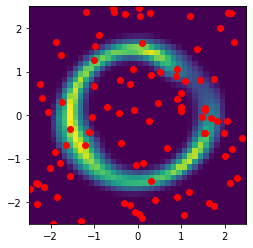

In [12]:
plt.imshow(np.mean(imgs, axis = 0), **imkwargs)
plt.scatter(coords[:,0], coords[:,1], c = 'r')

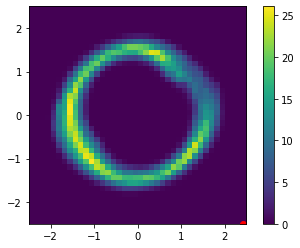

In [13]:
idx = np.random.randint(len(store))
plt.scatter(*store[idx][1], c="r")
plt.imshow(store[idx][0]['image'], **imkwargs)
plt.colorbar()

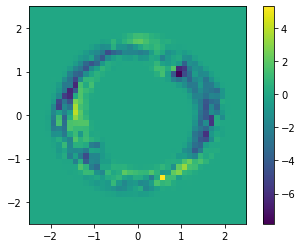

In [14]:
plt.imshow(store[1][0]['image']-store[-1][0]['image'], **imkwargs)
plt.colorbar()

### Train

In [15]:
torch.set_default_tensor_type(torch.FloatTensor)
dataset = swyft.Dataset(NSIM, prior, store)#, simhook = noise)
# post = swyft.Posteriors(dataset)

In [16]:
class DownsampleLinearHead(swyft.Module):
    def __init__(self, obs_shapes):
        super().__init__(obs_shapes=obs_shapes)

        image_shape = obs_shapes["image"]
        self.onl_f = swyft.networks.OnlineNormalizationLayer(
            image_shape, use_average_std=False
        )

        self.factor = 8
        downscaled_image_shape = (
            image_shape[0] // self.factor,
            image_shape[1] // self.factor,
        )
        self.avg2d = torch.nn.AvgPool2d((self.factor, self.factor))

        self.n_features = 8
        self.layers = torch.nn.Linear(np.prod(downscaled_image_shape), self.n_features)

    def forward(self, obs):
        x = obs["image"]
        nbatch = len(x)
        x = self.onl_f(x)
        x = self.avg2d(x.unsqueeze(1)).squeeze(1)
        x = self.layers(x.view(nbatch, -1))
        return x

In [17]:
if not DSLnet in os.listdir():
    print(f'Training {DSLnet}!')
    torch.set_default_tensor_type(torch.FloatTensor)
    marginals = [(0, 1)]  #, (0,), (1,)]
    post = swyft.Posteriors(dataset)
    post.add(
            marginals,
            head=DownsampleLinearHead,
            device="cuda",
        )

    post.train(marginals, max_epochs = 10)

    post.save(DSLnet)

print(f'Loading {DSLnet}!')
post = swyft.Posteriors.load(DSLnet).to(DEVICE)

Loading DSLnet-M11.pt!


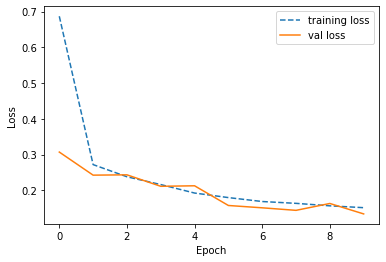

In [18]:
def get_losses(post):
        
    keys = list(post._ratios.keys())
    assert len(keys) == 1
    losses = post._ratios[keys[0]]._train_diagnostics
    assert len(losses) == 1
    tl = losses[0]['train_loss']
    vl = losses[0]['valid_loss']
    epochs = np.arange(len(tl))
    return epochs, tl, vl

def plot_losses(post):
    fig, ax = plt.subplots(1, 1)
    
    epochs, tl, vl = get_losses(post)
    ax.plot(epochs, tl, '--', label = f'training loss')
    ax.plot(epochs, vl, '-', label = f'val loss')
    
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
#     ax.set_yscale('log')
    plt.legend()
    plt.show()
      
plot_losses(post)

In [19]:
img_0 = store[idx][0]['image']
L1, L2 = tensor(img_0.shape)
assert L1 == L2
L = L1.item()
print(f'L = {L}')

L = 40


In [20]:
def coord_uv(coords_u, lows, highs):
#     highs_l = np.repeat(highs, coords_u)
#     lows_l = np.repeat(lows, coords_u)
    highs_l = np.full_like(coords_u, highs)
    lows_l = np.full_like(coords_u, lows)
    
    v = lambda u: (highs_l - lows_l) * u + lows_l
    coords_v = v(coords_u)
    return coords_v

def coord_to_map(XY_u):
    
    y0, y1, x0, x1 = -2.5, 2.5, -2.5, 2.5
    lows, highs = -2.5, 2.5
    res = 0.125
    
    XY = XY_u
    XY2 = coord_uv(XY_u.numpy(), lows, highs)
    
    n_batch =  XY.shape[0]
    n_coords = XY.shape[1]
    
    x_add = int(np.abs(x0 - lows) / res)
    y_add = int(np.abs(y0 - lows) / res)
        
    binary_map = torch.zeros((n_batch, L,L), device = DEVICE)
    binary_map2 = torch.zeros((n_batch, L,L), device = DEVICE)
    
    x, y = XY[:,0::2], XY[:,1::2]
    x2, y2 = XY2[:,0::2], XY2[:,1::2]

    x_i = torch.floor((x*L).flatten()).type(torch.long) 
    y_i = torch.floor((y*L).flatten()).type(torch.long) 
    
    x_i2 = torch.floor((x*(L-2*x_add)).flatten()).type(torch.long) + x_add
    y_i2 = torch.floor((y*(L-2*y_add)).flatten()).type(torch.long) + y_add

    if n_coords != 0:
        i   = torch.floor(torch.arange(0, n_batch, 1/n_coords*2).to(DEVICE)).type(torch.long) 
    
        xx = tuple(torch.stack((i, y_i, x_i)))
        xx2 = tuple(torch.stack((i, y_i2, x_i2)))
        binary_map[xx] = 1
        binary_map2[xx2] = 1

    return binary_map, binary_map2
    

class DoubleConv(swyft.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False), # bias = False becaise BatchNorm2d is set
            nn.BatchNorm2d(out_channels), # BatchNorm2d were not known when paper came out
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(swyft.Module):
    def __init__(self, n_features, marginals):
        super().__init__(n_features, marginals) 
#         super(UNET, self).__init__()
        
        self.marginals = marginals
        self.n_features = n_features
        
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # keep size the same
        
        in_channels=1
        out_channels=2
        features=[64, 128, 256, 512]

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
        

    def forward(self, sims, target):
                
        sims = sims.view(-1, L, L)
#         z = torch.zeros(*sims.shape, device = DEVICE)                
        z, z2 = coord_to_map(target)
    
        
        ############# UNet Start ###
        x = sims
        n_batch = len(x)
        x = x.unsqueeze(1)
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1] # reverse list

        # the upsampling
        for idx in range(0, len(self.ups), 2): # step of 2 because we want up - double column - up - double column
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2] # //2 because we want still steps of one

            # if statement because we can put in shapes that are not divisble by two around 19:00 of video
            if x.shape != skip_connection.shape: 
                x = TF.resize(x, size=skip_connection.shape[2:]) # hopefully does not impact accuracy too much

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        x = self.final_conv(x)
        ############# UNet End ###

        
                
        # L[C]
        x_new = x[:,0] * (1 - z2) + x[:,1] * z2
        
        
#         if len(x) != 0:
            
#             u = target[0]
#             v = coord_uv(target[0].numpy(), -1, 1)

        
#             plt_imshow([x[0][0], x[0][1], x_new[0], z[0], z2[0]], 
#                        titles = ['lnr0', 'lnr1', 'lnr[z]', 'z', 'z2'],
# #                        scatter = [v],
#                        cbar = True, size_y = 3, **imkwargs)
        
        x = x_new
        x = x.view(-1, self.n_features)
        return x

class CustomHead(swyft.Module):

    def __init__(self, obs_shapes) -> None:
        super().__init__(obs_shapes=obs_shapes)
        self.n_features = torch.prod(tensor(obs_shapes['image']))

    def forward(self, obs) -> torch.Tensor:
        x = obs["image"]
        n_batch = len(x)
        x = x.view(n_batch, self.n_features)
        return x

In [21]:
# optimizer_args: dict = dict(lr=1e-3)
# scheduler_args: dict = dict(factor=0.1, patience=5)

In [22]:
if not UNet in os.listdir():
    print(f'Training {UNet}!')

    torch.set_default_tensor_type(torch.FloatTensor)
    marginals = [i for i in range(L**2)]
    post = swyft.Posteriors(dataset)
    post.add(marginals, device = DEVICE, head = CustomHead, tail = UNET)
    post.train(marginals, max_epochs = 3, 
              optimizer_args = dict(lr=3e-5),
              scheduler_args = dict(factor=5e-4, patience=2))
    post.save(UNet)

print(f'Loading {UNet}!')  
post = swyft.Posteriors.load(UNet).to(DEVICE)

Loading UNet-M11.pt!


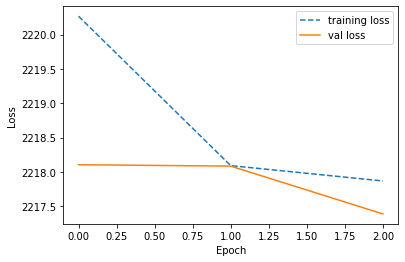

In [23]:
plot_losses(post)

### UNet posteriors

In [24]:
grid = torch.linspace(0,(L-1)/L,L)
x, y = torch.meshgrid(grid, grid, indexing = 'xy')
xy_full = torch.transpose(torch.stack((x.flatten(), y.flatten())), 0, 1).flatten()
xy_empty = tensor(())

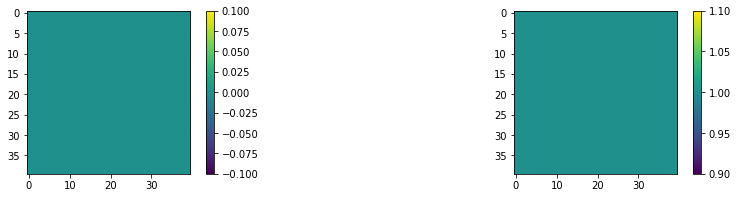

In [25]:
plots = [coord_to_map(xy.view(1, -1).to(DEVICE))[1].cpu().squeeze() for xy in [xy_empty, xy_full]]
plt_imshow(plots, cbar = True, size_y = 3)

In [26]:
def ratio(w):
    r = np.zeros((L**2))
    for i, (key, value) in enumerate(w.items()):
        r[i] = value
    return r.T.reshape(L, L)

def get_ratio(obs0, coords):
    samples = post.sample_elias(N = 1, obs0 = (obs0), n_batch = 1, v = coords.view(1, -1))
    v = samples['v']
    w = samples['weights']
    return ratio(w)

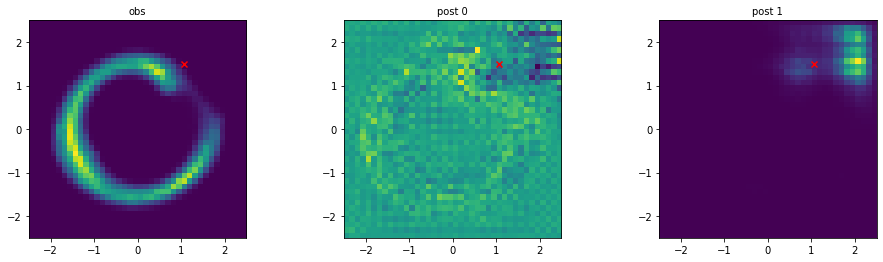

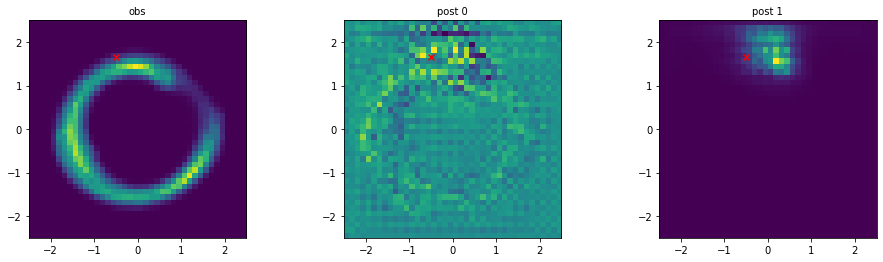

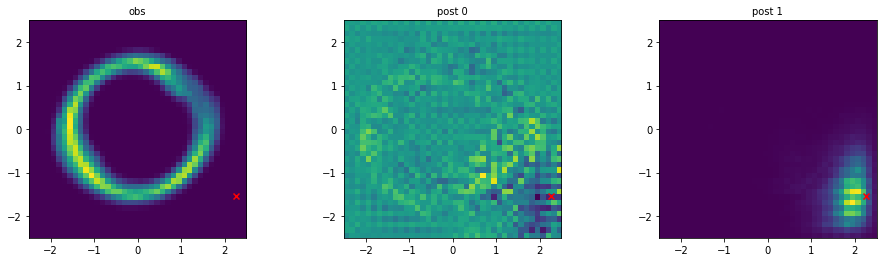

In [31]:
torch.set_default_tensor_type(torch.FloatTensor)  # HACK
post = swyft.Posteriors.load(UNet).to(DEVICE)

p_1s = []
v0s  = []
for i in np.random.randint(0, len(store), 3):
    obs0 = store[i][0]
    v0 = store[i][1]

    p_0 = get_ratio(obs0, xy_empty)/(L*L)
    p_1 = get_ratio(obs0, xy_full)/(L*L)
    
    plots = [obs0['image'], p_0, p_1]
    plt_imshow(plots, titles = ['obs', 'post 0', 'post 1'], scatter = [v0]*len(plots), size_y = 4, **imkwargs)
        
    p_1s.append(p_1)
    v0s.append(v0)
    
    plt.show()
        
torch.set_default_tensor_type(torch.cuda.FloatTensor)  # HACK

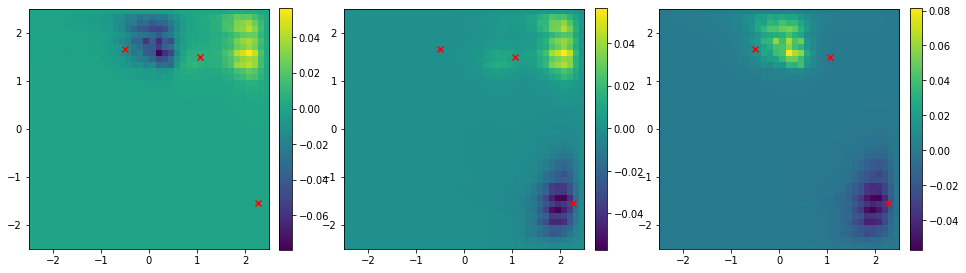

In [32]:
plt_imshow([p_1s[0] - p_1s[1], p_1s[0] - p_1s[2], p_1s[1] - p_1s[2]], cbar = True, scatter = np.array([np.array(v0s).T]*3), **imkwargs)

### Check posteriors

In [29]:
post = swyft.Posteriors.load(DSLnet).to(DEVICE)

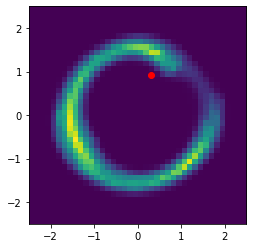

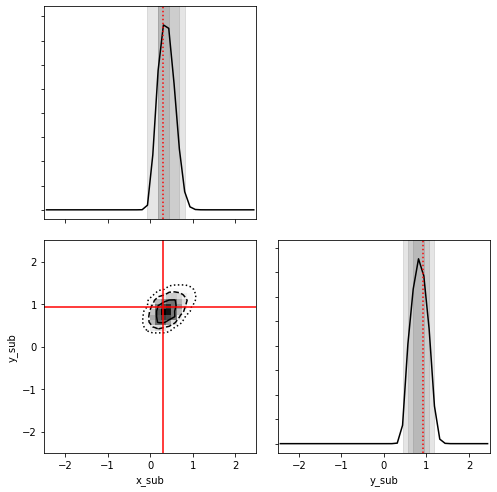

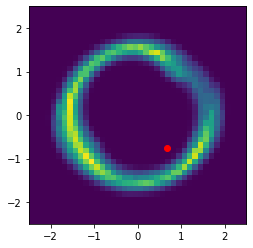

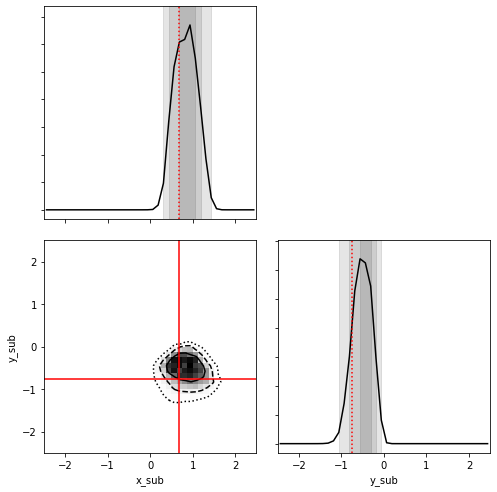

In [30]:
for idx in range(1,3):
    torch.set_default_tensor_type(torch.FloatTensor)  # HACK
#     idx = 10 # choose different observation 
    IMAGE = store[idx][0]["image"]
    v0 = store[idx][1]
    samples = post.sample(100000, {"image": IMAGE})
    
    plt.imshow(IMAGE, **imkwargs)
    plt.scatter(*v0, c = 'r')
    plt.show()

    swyft.plot_corner(
        samples, 
        [0, 1], 
        color='k', 
        figsize = (8,8), 
        truth=v0, 
        bins = 40);
    plt.show()

    torch.set_default_tensor_type(torch.cuda.FloatTensor)  # HACK

##### 